Celda 1: 1. Configuración e Importaciones
En esta celda, importamos todas las librerías necesarias y definimos nuestra semilla de reproducibilidad (RANDOM_SEED).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Preprocesamiento y Modelado ---
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# --- Calibración y Métricas ---
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import brier_score_loss, roc_auc_score

# --- Configuración Global ---
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# (Opcional) Montar Google Drive si tus datos están ahí
# from google.colab import drive
# drive.mount('/content/drive')

Celda 2: 2. Carga y Preparación de Datos
Cargamos el dataset limpio (credit_data_clean.csv) que generaste en tu EDA. Luego, definimos qué columnas son numéricas y cuáles categóricas para el preprocesamiento.

In [ ]:
# --- Cargar Datos Limpios ---
# Asegúrate de que esta ruta sea correcta en tu entorno Colab
# Sube el archivo 'credit_data_clean.csv' a la carpeta 'datasets_limpios'
DATA_PATH = Path("/content/credit_data_clean.csv")

if not DATA_PATH.exists():
    print(f"Error: No se encontró el archivo en {DATA_PATH}")
    print("Por favor, sube tu archivo 'credit_data_clean.csv' a la carpeta 'datasets_limpios' en Colab.")
    # Si subes el archivo directamente a /content/
    # DATA_PATH = Path("credit_data_clean.csv")
    # df = pd.read_csv(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

print(f"Dataset limpio cargado: {df.shape}")

# --- Definir Features (X) y Target (y) ---
target_col = "target"
y = df[target_col]
X = df.drop(columns=target_col)

# --- Identificar Tipos de Variables (basado en tu EDA) ---
# Columnas numéricas identificadas en tu EDA
numerical_features = ['duration_months', 'credit_amount', 'age']

# Todas las demás columnas en X son categóricas u ordinales
categorical_features = X.columns.drop(numerical_features).tolist()

print(f"\nFeatures Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Features Categóricas ({len(categorical_features)}): {categorical_features[:5]}...")

Dataset limpio cargado: (1000, 21)

Features Numéricas (3): ['duration_months', 'credit_amount', 'age']
Features Categóricas (17): ['checking_account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since']...


Celda 3: 3. Definir Preprocesador y Split Estratificado
Creamos el ColumnTransformer para escalar las numéricas y aplicar One-Hot Encoding a las categóricas. Luego, hacemos el split 80/20 estratificado.

In [ ]:
# --- 1. Crear el Pipeline de Preprocesamiento ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    # handle_unknown='ignore' es útil si el test set tuviera una categoría no vista
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Pipeline de preprocesamiento creado.")

# --- 2. División 80/20 Estratificada ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y  # Asegura la misma proporción de clases en train y test
)

print(f"\nTamaño de Entrenamiento: {X_train.shape[0]} ({y_train.mean():.2f} % 'Good')")
print(f"Tamaño de Prueba: {X_test.shape[0]} ({y_test.mean():.2f} % 'Good')")

Pipeline de preprocesamiento creado.

Tamaño de Entrenamiento: 800 (0.70 % 'Good')
Tamaño de Prueba: 200 (0.70 % 'Good')


Celda 4: 4. Entrenar Modelo Base y Modelo Calibrado
Aquí creamos dos versiones:

pipe_lr_base: El modelo de Regresión Logística estándar.

pipe_lr_calibrated: El modelo envuelto en CalibratedClassifierCV con method='isotonic'. Este wrapper utiliza validación cruzada interna (cv=5) sobre los datos de X_train para calibrar las probabilidades.

In [ ]:
# --- 1. Definir el Pipeline del Modelo Base ---
pipe_lr_base = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        solver='liblinear'
    ))
])

# --- 2. Definir el Pipeline del Modelo Calibrado ---
# CalibratedClassifierCV envuelve al pipeline base
# method='isotonic' es flexible y no asume una forma sigmoide
# cv=5 usa validación cruzada (solo sobre datos de train) para calibrar
pipe_lr_calibrated = CalibratedClassifierCV(
    pipe_lr_base,
    method='isotonic',
    cv=5
)

# --- 3. Entrenar ambos modelos ---
print("Entrenando Modelo Base...")
pipe_lr_base.fit(X_train, y_train)

print("Entrenando Modelo Calibrado (Isotónico)...")
pipe_lr_calibrated.fit(X_train, y_train)

print("Entrenamiento completado.")

Entrenando Modelo Base...
Entrenando Modelo Calibrado (Isotónico)...
Entrenamiento completado.


Celda 5: 5. Comparar Calibración (Métricas y Gráficos)
Comparamos el Brier Score (la métrica clave para calibración; más bajo es mejor) y el AUC (discriminación). Luego, generamos las Curvas de Fiabilidad para ver visualmente la mejora.

=== Comparativa de Métricas (Brier Score: más bajo es mejor) ===


,Brier Score,AUC
LR Base,0.148271,0.823810
LR Calibrada (Isotónica),0.152411,0.816726


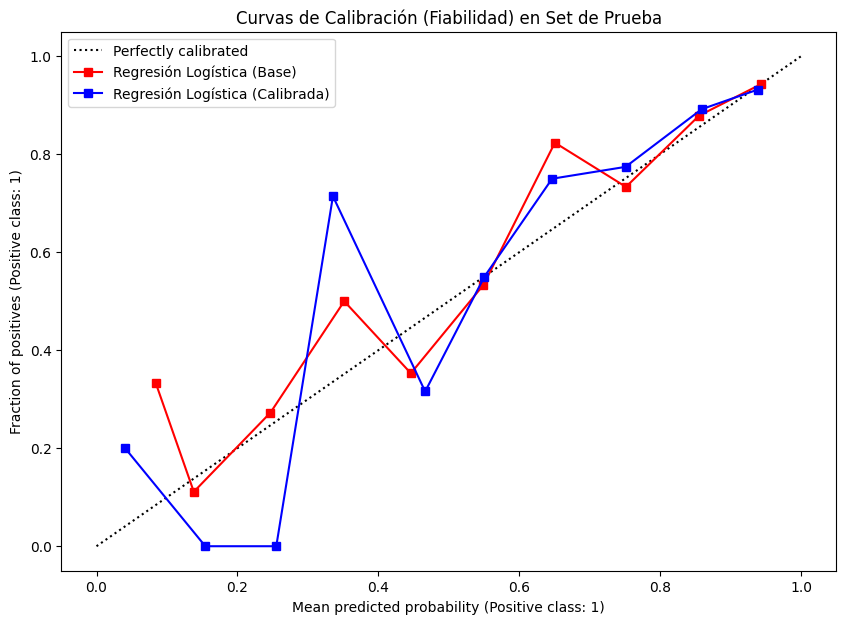

In [ ]:
# --- 1. Obtener probabilidades en el set de PRUEBA ---
prob_base = pipe_lr_base.predict_proba(X_test)[:, 1]
prob_calibrated = pipe_lr_calibrated.predict_proba(X_test)[:, 1]

# --- 2. Calcular Métricas ---
metrics = {
    "LR Base": {
        "Brier Score": brier_score_loss(y_test, prob_base),
        "AUC": roc_auc_score(y_test, prob_base)
    },
    "LR Calibrada (Isotónica)": {
        "Brier Score": brier_score_loss(y_test, prob_calibrated),
        "AUC": roc_auc_score(y_test, prob_calibrated)
    }
}

metrics_df = pd.DataFrame(metrics).T
print("=== Comparativa de Métricas (Brier Score: más bajo es mejor) ===")
display(metrics_df)

# --- 3. Visualizar Curvas de Calibración ---
fig, ax = plt.subplots(figsize=(10, 7))

# Plot del modelo base
CalibrationDisplay.from_predictions(
    y_test, prob_base, n_bins=10, ax=ax,
    name="Regresión Logística (Base)", color='red'
)

# Plot del modelo calibrado
CalibrationDisplay.from_predictions(
    y_test, prob_calibrated, n_bins=10, ax=ax,
    name="Regresión Logística (Calibrada)", color='blue'
)

ax.set_title("Curvas de Calibración (Fiabilidad) en Set de Prueba")
plt.legend(loc="upper left")
plt.show()

Celda 6: 6. Reporte de Coeficientes y Odds Ratios
Esta es la parte clave. Extraemos los coeficientes del modelo calibrado, obtenemos los nombres de las features (incluyendo las generadas por el One-Hot Encoder) y calculamos los Odds Ratios (np.exp(coeficiente)).

In [ ]:
# --- 1. Extraer el pipeline y el preprocesador ---
# CalibratedClassifierCV crea un ensamble de 5 modelos (por el cv=5).
# Extraemos el pipeline del primer clasificador calibrado [0].
# El .base_estimator_ es el pipeline original que le pasamos.
pipeline_entrenado = pipe_lr_calibrated.calibrated_classifiers_[0].base_estimator_

# Accedemos a los pasos del pipeline
preprocessor_entrenado = pipeline_entrenado.named_steps['preprocessor']
modelo_lr_entrenado = pipeline_entrenado.named_steps['model']

# --- 2. Obtener nombres de features ---
# get_feature_names_out() nos da los nombres de las features escaladas y one-hot-encoded
feature_names = preprocessor_entrenado.get_feature_names_out()

# --- 3. Obtener coeficientes ---
coefficients = modelo_lr_entrenado.coef_[0]

# --- 4. Crear DataFrame de Odds Ratios ---
odds_ratios_df = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente (Log-Odds)': coefficients,
    'Odds Ratio': np.exp(coefficients)
}).sort_values(by='Odds Ratio', ascending=False)

odds_ratios_df['Impacto'] = odds_ratios_df['Odds Ratio'].apply(
    lambda x: 'Positivo (Good)' if x > 1 else 'Negativo (Bad)'
)

print("\n" + "="*50)
print("REPORTE DE COEFICIENTES Y ODDS RATIOS (del Modelo Calibrado)")
print("="*50)

# --- Mostrar resultados ---
print(f"\n--- Features con Mayor Impacto Positivo (Favorecen 'Good Credit') ---")
display(odds_ratios_df.head(10))

print(f"\n--- Features con Mayor Impacto Negativo (Favorecen 'Bad Credit') ---")
display(odds_ratios_df.tail(10).sort_values(by='Odds Ratio', ascending=True))

AttributeError: '_CalibratedClassifier' object has no attribute 'base_estimator_'